# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns

import math
import sklearn.metrics
from sklearn.metrics import f1_score, confusion_matrix, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MaxAbsScaler
from scipy.spatial import distance


from sklearn.model_selection import train_test_split

from IPython.display import display

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [2]:
df = pd.read_csv('/datasets/insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [3]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [4]:
df.sample(10)

gender   age   income  family_members  insurance_benefits
319        1  23.0  33100.0               0                   0
2568       1  20.0  40200.0               0                   0
1027       0  37.0  59900.0               1                   0
3810       1  42.0  34400.0               3                   0
2838       0  27.0  18600.0               0                   0
3559       0  30.0  46500.0               2                   0
3772       1  33.0  35900.0               0                   0
1479       0  19.0  37500.0               0                   0
246        1  27.0  39500.0               1                   0
175        0  33.0  30600.0               2                   0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [6]:
# we may want to fix the age type (from float to int) though this is not critical
# write your conversion here if you choose:
df['age'] = df['age'].astype(int)

In [7]:
# check to see that the conversion was successful
print(df['age'].dtype)
print(df.head())

int64
   gender  age   income  family_members  insurance_benefits
0       1   41  49600.0               1                   0
1       0   46  38000.0               1                   1
2       0   29  21000.0               0                   0
3       0   21  41700.0               2                   0
4       1   28  26100.0               0                   0


In [8]:
# now have a look at the data's descriptive statistics. 
# Does everything look okay?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [9]:
df.describe()

gender          age        income  family_members  \
count  5000.000000  5000.000000   5000.000000     5000.000000   
mean      0.499000    30.952800  39916.360000        1.194200   
std       0.500049     8.440807   9900.083569        1.091387   
min       0.000000    18.000000   5300.000000        0.000000   
25%       0.000000    24.000000  33300.000000        0.000000   
50%       0.000000    30.000000  40200.000000        1.000000   
75%       1.000000    37.000000  46600.000000        2.000000   
max       1.000000    65.000000  79000.000000        6.000000   

       insurance_benefits  
count         5000.000000  
mean             0.148000  
std              0.463183  
min              0.000000  
25%              0.000000  
50%              0.000000  
75%              0.000000  
max              5.000000

In [10]:
df.duplicated().sum()

153

In [11]:
duplicates = df[df.duplicated()]
print(duplicates.head(10))

      gender  age   income  family_members  insurance_benefits
281        1   39  48100.0               1                   0
488        1   24  32900.0               1                   0
513        0   31  37400.0               2                   0
718        1   22  32600.0               1                   0
785        0   20  35800.0               0                   0
869        1   24  33100.0               1                   0
887        1   19  35500.0               0                   0
1004       1   29  42400.0               0                   0
1089       0   27  46800.0               2                   0
1091       1   41  34000.0               1                   0


In [12]:
# Coincidental duplicates being dropped for a cleaner process ahead, 
# such as to prevent artificially inflating knn numbers, overfitting, 
# and distortion of Regression lines.
df = df.drop_duplicates()
df.reset_index(drop=True, inplace=True)

In [13]:
print(df.duplicated().sum())

0


## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

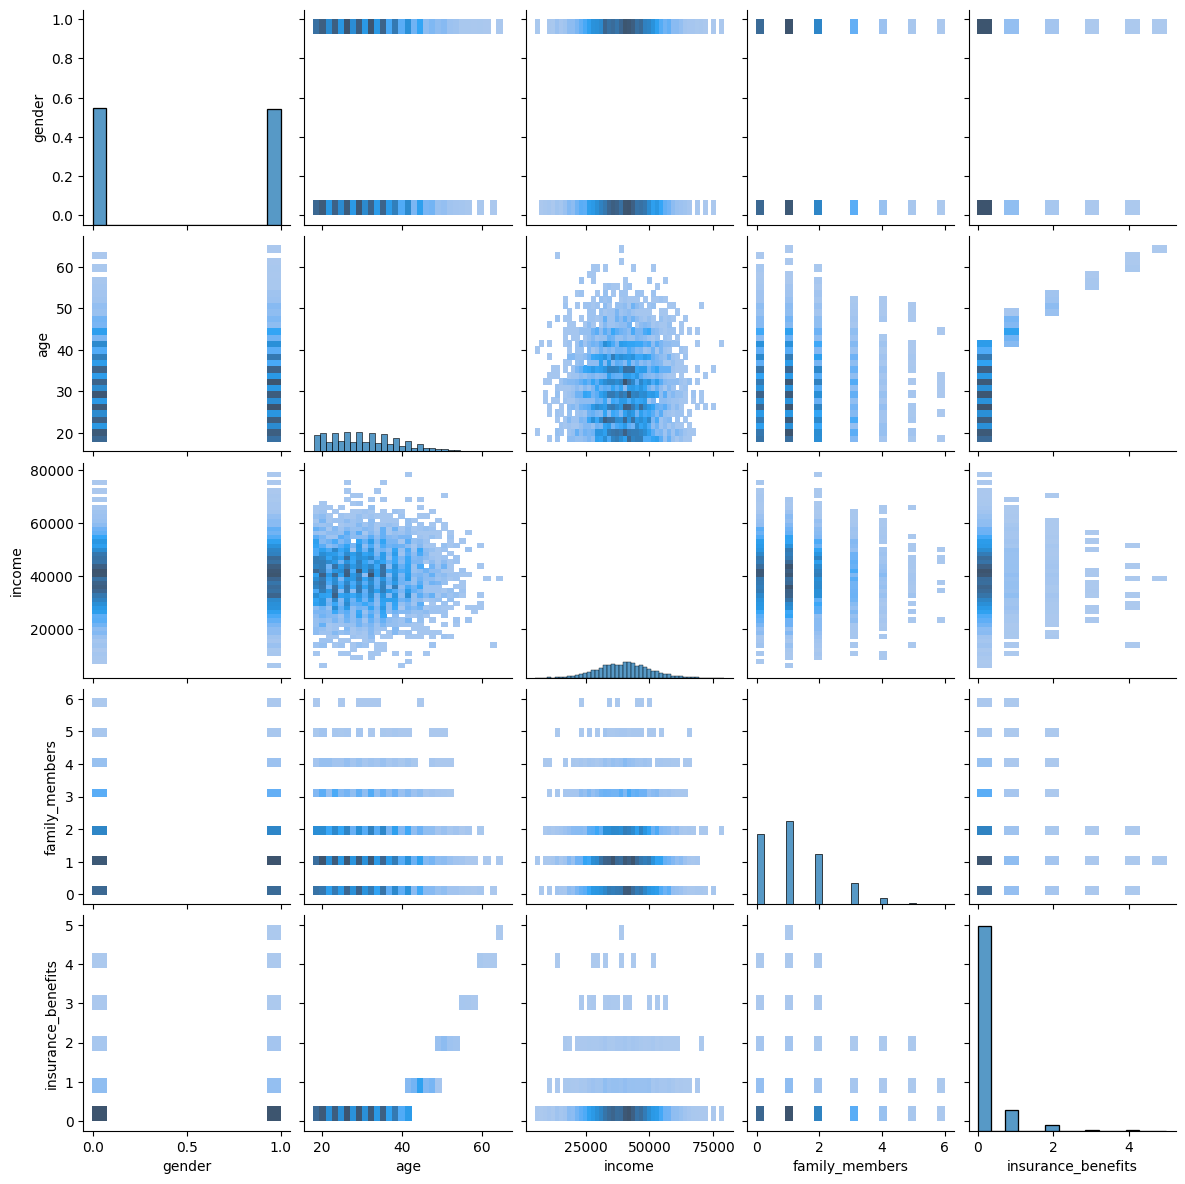

In [14]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [15]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [16]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """
    nbrs = NearestNeighbors(n_neighbors=k+1, metric=metric).fit(df[feature_names]) # <your code here> 
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Scaling the data.

In [17]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [18]:
df_scaled.sample(5)

gender       age    income  family_members  insurance_benefits
1662     1.0  0.692308  0.743038        0.166667                   1
3030     0.0  0.507692  0.459494        0.000000                   0
3457     0.0  0.600000  0.651899        0.000000                   0
3466     0.0  0.369231  0.517722        0.166667                   0
4475     1.0  0.430769  0.206329        0.166667                   0

Now, let's get similar records for a given one for every combination

In [19]:
# Finding 5 neighbors for n
n = 0
k = 5

In [20]:
# Case 1: Unscaled + Euclidean
knn_unscaled_euclidean = get_knn(df, n, k, 'euclidean')
knn_unscaled_euclidean

gender  age   income  family_members  insurance_benefits  distance
0          1   41  49600.0               1                   0  0.000000
1992       1   41  49600.0               0                   0  1.000000
1214       0   42  49600.0               0                   1  1.732051
3916       1   44  49600.0               2                   1  3.162278
3334       0   38  49600.0               0                   0  3.316625

In [21]:
# Case 2: Unscaled + Manhattan
knn_unscaled_manhattan = get_knn(df, n, k, 'manhattan')
knn_unscaled_manhattan

gender  age   income  family_members  insurance_benefits  distance
0          1   41  49600.0               1                   0       0.0
1992       1   41  49600.0               0                   0       1.0
1214       0   42  49600.0               0                   1       3.0
3916       1   44  49600.0               2                   1       4.0
3334       0   38  49600.0               0                   0       5.0

In [22]:
# Case 3: Scaled + Euclidean
knn_scaled_euclidean = get_knn(df_scaled, n, k, 'euclidean')
knn_scaled_euclidean 

gender       age    income  family_members  insurance_benefits  distance
0        1.0  0.630769  0.627848        0.166667                   0  0.000000
2632     1.0  0.630769  0.634177        0.166667                   0  0.006329
133      1.0  0.615385  0.636709        0.166667                   0  0.017754
4720     1.0  0.646154  0.637975        0.166667                   1  0.018418
3192     1.0  0.646154  0.651899        0.166667                   1  0.028550

In [23]:
# Case 4: Scaled + Manhattan
knn_scaled_manhattan = get_knn(df_scaled, n, k, 'manhattan')
knn_scaled_manhattan

gender       age    income  family_members  insurance_benefits  distance
0        1.0  0.630769  0.627848        0.166667                   0  0.000000
2632     1.0  0.630769  0.634177        0.166667                   0  0.006329
133      1.0  0.615385  0.636709        0.166667                   0  0.024245
4720     1.0  0.646154  0.637975        0.166667                   1  0.025511
2072     1.0  0.630769  0.596203        0.166667                   0  0.031646

Answers to the questions

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 



Yes, because KNN is distance-based, so unscaled features like income in thousands and age in tens can dominate the distance calculation. Scaling ensures all features contribute equally. 

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 


Euclidean is more sensitive to outliers than Manhattan, because the Euclidean utilizes the squared differences for its calculations, as opposed to Manhattan, which uses absolute differences, leading to less sensitivity to scaling as well. 

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [24]:
# calculate the target
df['insurance_benefits_received'] = (df['insurance_benefits'] > 0).astype(int) #<your code here>

In [25]:
# check for the class imbalance with value_counts()
df['insurance_benefits_received'].value_counts(normalize=True)
# <your code here>

0    0.883846
1    0.116154
Name: insurance_benefits_received, dtype: float64

In [26]:
X = df[['gender', 'age', 'income', 'family_members']]  
y = df['insurance_benefits_received']                 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size= 0.3, random_state=42)

In [27]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [28]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [29]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, len(y_test)) # <your code here> 
        
    eval_classifier(y_test, y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.89140893 0.        ]
 [0.10859107 0.        ]]

The probability: 0.12
F1: 0.12
Confusion Matrix
[[0.78487973 0.10652921]
 [0.09484536 0.0137457 ]]

The probability: 0.50
F1: 0.17
Confusion Matrix
[[0.44604811 0.44536082]
 [0.05841924 0.05017182]]

The probability: 1.00
F1: 0.20
Confusion Matrix
[[0.         0.89140893]
 [0.         0.10859107]]



In [30]:
scaler = MaxAbsScaler()

In [31]:
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test) 

In [32]:
for k in range(1, 11):
    print(f'\n--- k = {k} ---')
    
    # Original data
    knn_original = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    y_pred_original = knn_original.predict(X_test)
    print('Original Data:')
    eval_classifier(y_test, y_pred_original)
    
    # Scaled data
    knn_scaled = KNeighborsClassifier(n_neighbors=k).fit(X_train_scaled, y_train)
    y_pred_scaled = knn_scaled.predict(X_test_scaled)
    print('Scaled Data:')
    eval_classifier(y_test, y_pred_scaled)


--- k = 1 ---
Original Data:
F1: 0.66
Confusion Matrix
[[0.86735395 0.02405498]
 [0.04261168 0.06597938]]
Scaled Data:
F1: 0.95
Confusion Matrix
[[0.88453608 0.00687285]
 [0.004811   0.10378007]]

--- k = 2 ---
Original Data:
F1: 0.47
Confusion Matrix
[[0.88522337 0.00618557]
 [0.07353952 0.03505155]]
Scaled Data:
F1: 0.95
Confusion Matrix
[[8.90721649e-01 6.87285223e-04]
 [9.62199313e-03 9.89690722e-02]]

--- k = 3 ---
Original Data:
F1: 0.45
Confusion Matrix
[[0.87285223 0.0185567 ]
 [0.07147766 0.0371134 ]]
Scaled Data:
F1: 0.95
Confusion Matrix
[[0.88728522 0.00412371]
 [0.00618557 0.1024055 ]]

--- k = 4 ---
Original Data:
F1: 0.16
Confusion Matrix
[[0.88934708 0.00206186]
 [0.09896907 0.00962199]]
Scaled Data:
F1: 0.94
Confusion Matrix
[[0.89003436 0.00137457]
 [0.01099656 0.0975945 ]]

--- k = 5 ---
Original Data:
F1: 0.17
Confusion Matrix
[[0.88659794 0.004811  ]
 [0.09828179 0.01030928]]
Scaled Data:
F1: 0.95
Confusion Matrix
[[0.88728522 0.00412371]
 [0.00687285 0.10171821]]

The KNN classifier performs better on scaled data which is visible through the increase in F1 scores throughout k results. 

Addressed :)

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [33]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y# <your code here>

    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1) # <your code here>
        y_pred = X2 @ self.weights # <your code here>
        
        return y_pred

In [34]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [35]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.77366729e-01  3.58042291e-02  1.95594888e-02  5.85336165e-07
 -1.21618420e-02]
RMSE: 0.36
R2: 0.66


In [52]:
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)  

In [53]:
print("\n=== Scaled Data ===")
lr_scaled = MyLinearRegression()
lr_scaled.fit(X_train_scaled, y_train)
print("Weights (scaled):", lr_scaled.weights)

y_pred_scaled = lr_scaled.predict(X_test_scaled)
eval_regressor(y_test, y_pred_scaled)


=== Scaled Data ===
Weights (scaled): [-0.97736673  2.32727489  0.01955949  0.04378315 -0.07297105]
RMSE: 0.36
R2: 0.66


Since Linear Regression assumes features are on similar scales, scaling is ensuring features like income and age contribute equally to the model. The scaled weights now reflect each feature properly. scaling does not change RMSE for Linear Regression, because any changes in the variables will be absorbed into the new coefficients.

One of the advantages of standardization in Linear Regression is that it allows us to interpret the importance of features based on the magnitude of their coefficients: the larger the coefficient, the more important the feature is. Without standardization, such interpretation is not possible because each coefficient also reflects the scale of its corresponding feature.
The second case where standardization is essential is in regularized linear regression models (Ridge, Lasso, and Elastic Net), since these models penalize the coefficients that are affected by scaling.

By the way, due to the nature of floating-point numbers, there may still be slight differences in the digits after the decimal point, which could be critical, for example, in competitions

# Task 4. Obfuscating Data

It's best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [38]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [39]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [40]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [41]:
assert np.linalg.det(P) != 0, "P is not invertible!"

Can you guess the customers' ages or income after the transformation?

Answer: No, the transformed data X^1 is obfuscated. Without knowing P, the original values are hidden.

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

Answer: We cannot guess the customers' ages or income after the transformation, but we can recover the original data as long as the matrix is invertible.

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [42]:
X_transformed = X @ P # obfuscating data

In [43]:
P_inv = np.linalg.inv(P) # inverting P 
X_recovered = X_transformed @ P_inv # recoverign og data

In [44]:
# Printing results for first 3 customers
print("Original Data (X):\n", X[:3])
print("\nTransformed Data (X' = X @ P):\n", X_transformed[:3])
print("\nRecovered Data (X' @ P^{-1}):\n", X_recovered[:3])

Original Data (X):
 [[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]]

Transformed Data (X' = X @ P):
 [[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]]

Recovered Data (X' @ P^{-1}):
 [[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [ 1.67952800e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [-6.23021448e-13  2.90000000e+01  2.10000000e+04 -2.03032656e-13]]


You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

Answer: The recovered values are not identical because of computational finite precision, causing matrix inversion and multiplication to have small errors. The fix to this issue is to round the recovered values to integers for age, family members, or 2 decimals for income. These small differences between the original and recovered data are due to floating-point arithmetic precision limitations.

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

Obfuscating data by multiplying a matrix by its inversion does not change the predictions of a linear regression model, with no impact to the predictive performance of the RMSE and R2 values. The weights (wp) transform, but predictions are the same, with P acting as a linear transformation of the feature space, still preserving the underlying relationships such as the hyperplane for regression. 

**Analytical proof**

Standard LA solution to minimize MSE is $w = (X^t X)^-1 X^ty$ with predicted values $y^ = Xw$. The obfuscated data appears as $X' = XP$, thus, the new weights are $wp = P^-1w$. And the predicted values using X' and wp are: $wp = P^-1(X^T * X)^-1X^Ty$.

 We can simplify everything even further. So the original weights are:

   $$w = (X^T X)^{-1} X^T y$$

Then we apply obfuscation ($w_P$). The obfuscated data is $X' = XP$, so the weights become:

   $$w_P = [(XP)^T XP]^{-1} (XP)^T y$$

Now, let's simplify $w_P$ and find the relationship between $w$ and $w_P$.


First, $X' = XP$. Substituting $X'$ back into the formula gives us:

$$w_P = [(XP)^T XP]^{-1} (XP)^T y$$

Applying the property of transpose to a product (i.e., $(AB)^T = B^T A^T$), we get:

$$w_P = [P^T X^T XP]^{-1} P^T X^T y$$

Using the property of matrix multiplication inverse (i.e., $(AB)^{-1} = B^{-1} A^{-1}$) when $A$ and $B$ are invertible, and knowing $P$ is invertible by definition, we simplify to:

$$w_P = P^{-1} (X^T X)^{-1} (P^T)^{-1} P^T X^T y$$

Since $P$ is invertible, $P^{-1} P^T = I$, where $I$ is the identity matrix, and $(P^T)^{-1} P^T = I$. Therefore, we can further simplify to:

$$w_P = P^{-1} (X^T X)^{-1} X^T y$$

Noticing that the term $(X^T X)^{-1} X^T y$ is exactly the formula for the original weights $w$, we get:

$$w_P = P^{-1} w$$



To find the predicted values $\hat{y}$ with $w_P$, we use:

$$\hat{y} = X' w_P = XP P^{-1} w$$

Since $PP^{-1} = I$, we simplify to:

$$\hat{y} = XIw = Xw$$



## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
-  XP obfucates features but preserves model performance                    <! your comment here !>
- Use $XP$ as the new feature matrix

In [45]:
while True:
    P = np.random.randn(X.shape[1], X.shape[1])  # Random square matrix
    if np.linalg.det(P) != 0:  # Checking invertibility
        break

In [46]:
X_transformed = X @ P # matrix multiplication

In [47]:
X_recovered = X_transformed @ P_inv # Recovering og data

In [48]:
model_original = LinearRegression().fit(X, y)
y_pred_original = model_original.predict(X)

In [49]:
model_transformed = LinearRegression().fit(X_transformed, y)
y_pred_transformed = model_transformed.predict(X_transformed)

In [50]:
rmse_original = np.sqrt(mean_squared_error(y, y_pred_original))
r2_original = r2_score(y, y_pred_original)

rmse_transformed = np.sqrt(mean_squared_error(y, y_pred_transformed))
r2_transformed = r2_score(y, y_pred_transformed)

In [51]:
print("Original coefficients:", model_original.coef_)
print("Transformed coefficients:", model_transformed.coef_)
print("\nOriginal RMSE:", rmse_original, "R²:", r2_original)
print("Transformed RMSE:", rmse_transformed, "R²:", r2_transformed)

Original coefficients: [ 9.46018141e-03  3.61640081e-02 -1.38991363e-07 -1.42517371e-02]
Transformed coefficients: [-0.0451984   0.04687902  0.04555581 -0.03034205]

Original RMSE: 0.3539387493152114 R²: 0.4302010044852066
Transformed RMSE: 0.3539387493152081 R²: 0.43020100448521736


We received the same values because linear regression is invariant to invertible linear transformations. RMSE/R2 match because model's predictive performance is unchanged, weights transform to compensate for $P$, but the underlying model is identical. 

# Conclusions

This computational test concludes that Data Obfuscation (XP) does not affect linear regression predictions or metrics. This is very useful for privacy reasons when machine learning as sensitive data can be hidden without sacrificing models performance. 

# Checklist

Type 'x' to check. Then press Shift+Enter.

# Appendices 

## Appendix A: Writing Formulas in Jupyter Notebooks

You can write formulas in your Jupyter Notebook in a markup language provided by a high-quality publishing system called $\LaTeX$ (pronounced "Lah-tech"), and they will look like formulas in textbooks.

To put a formula in a text, put the dollar sign (\\$) before and after the formula's text e.g. $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

If a formula should be in its own paragraph, put the double dollar sign (\\$\\$) before and after the formula text e.g.

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

The markup language of [LaTeX](https://en.wikipedia.org/wiki/LaTeX) is very popular among people who use formulas in their articles, books and texts. It can be complex but its basics are easy. Check this two page [cheatsheet](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) for learning how to compose the most common formulas.

## Appendix B: Properties of Matrices

Matrices have many properties in Linear Algebra. A few of them are listed here which can help with the analytical proof in this project.

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>